# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.362373
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Because there are 10 classes,for every training data,we have 1/10 probability to predict correctly for random guess.When we random initialize weight matrix,the loss(averaged over number of training data)should be the negative probability*


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.333630 analytic: 0.333630, relative error: 7.002254e-08
numerical: -1.308011 analytic: -1.308011, relative error: 2.535724e-08
numerical: 4.887406 analytic: 4.887406, relative error: 1.311332e-08
numerical: -2.265922 analytic: -2.265922, relative error: 6.809674e-09
numerical: 0.561071 analytic: 0.561071, relative error: 3.948073e-08
numerical: 2.118262 analytic: 2.118262, relative error: 1.097828e-08
numerical: -0.079711 analytic: -0.079711, relative error: 4.909711e-07
numerical: -4.095873 analytic: -4.095873, relative error: 6.082462e-09
numerical: 0.055408 analytic: 0.055408, relative error: 8.156207e-07
numerical: -1.383741 analytic: -1.383741, relative error: 2.706428e-08
numerical: 0.103599 analytic: 0.103599, relative error: 4.025998e-07
numerical: 0.079909 analytic: 0.079909, relative error: 1.117456e-07
numerical: -0.914033 analytic: -0.914033, relative error: 1.822234e-08
numerical: 0.041773 analytic: 0.041773, relative error: 1.581980e-07
numerical: -1.859992 a

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.362373e+00 computed in 0.350445s
vectorized loss: 2.362373e+00 computed in 0.028742s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 1e-6,1e-5,1e-4,2e-7,2e-6,2e-5]
regularization_strengths = [0,0.2,0.5,0.8,1,5,1e1,1e2, 1e3]
num_iters=500

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
#         tic = time.time()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=num_iters, verbose=True)
#         toc = time.time()
#         print 'That took %fs' % (toc - tic)
        y_train_pred = softmax.predict(X_train)
        train_acc=np.mean(y_train == y_train_pred)
        print 'training accuracy: %f' % (train_acc)
        y_val_pred = softmax.predict(X_val)
        val_acc=np.mean(y_val == y_val_pred)
        print 'validation accuracy: %f' % (val_acc)
        results[(lr,reg)]=(train_acc,val_acc)
        print (lr,reg),':',(train_acc,val_acc)
        if val_acc>best_val:
            best_val=val_acc
            best_softmax=softmax

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 500: loss 6.491939
iteration 100 / 500: loss 4.234650
iteration 200 / 500: loss 3.695711
iteration 300 / 500: loss 3.364866
iteration 400 / 500: loss 3.442502
training accuracy: 0.204694
validation accuracy: 0.204000
(1e-07, 0) : (0.20469387755102042, 0.20399999999999999)
iteration 0 / 500: loss 6.327289
iteration 100 / 500: loss 3.727262
iteration 200 / 500: loss 3.564677
iteration 300 / 500: loss 3.340660
iteration 400 / 500: loss 3.078554
training accuracy: 0.207367
validation accuracy: 0.215000
(1e-07, 0.2) : (0.20736734693877551, 0.215)
iteration 0 / 500: loss 5.164761
iteration 100 / 500: loss 4.162697
iteration 200 / 500: loss 3.214572
iteration 300 / 500: loss 3.197385
iteration 400 / 500: loss 3.145939
training accuracy: 0.206735
validation accuracy: 0.224000
(1e-07, 0.5) : (0.20673469387755103, 0.224)
iteration 0 / 500: loss 5.052828
iteration 100 / 500: loss 3.429258
iteration 200 / 500: loss 3.158979
iteration 300 / 500: loss 3.345436
iteration 400 / 500: loss

iteration 100 / 500: loss 34.605607
iteration 200 / 500: loss 27.624696
iteration 300 / 500: loss 35.325910
iteration 400 / 500: loss 24.720028
training accuracy: 0.271082
validation accuracy: 0.254000
(0.0001, 0.5) : (0.27108163265306123, 0.254)
iteration 0 / 500: loss 5.343788
iteration 100 / 500: loss 40.180621
iteration 200 / 500: loss 36.088913
iteration 300 / 500: loss 18.612181
iteration 400 / 500: loss 28.202786
training accuracy: 0.313714
validation accuracy: 0.312000
(0.0001, 0.8) : (0.31371428571428572, 0.312)
iteration 0 / 500: loss 5.689531
iteration 100 / 500: loss 40.434274
iteration 200 / 500: loss 46.014713
iteration 300 / 500: loss 28.044018
iteration 400 / 500: loss 41.761828
training accuracy: 0.296265
validation accuracy: 0.279000
(0.0001, 1) : (0.296265306122449, 0.27900000000000003)
iteration 0 / 500: loss 6.181056
iteration 100 / 500: loss 28.968634
iteration 200 / 500: loss 25.437519
iteration 300 / 500: loss 28.060494
iteration 400 / 500: loss 20.576479
traini

iteration 100 / 500: loss 4.702445
iteration 200 / 500: loss 7.066037
iteration 300 / 500: loss 6.267966
iteration 400 / 500: loss 9.359118
training accuracy: 0.302551
validation accuracy: 0.284000
(2e-05, 1) : (0.30255102040816328, 0.28399999999999997)
iteration 0 / 500: loss 5.304822
iteration 100 / 500: loss 7.407025
iteration 200 / 500: loss 4.896826
iteration 300 / 500: loss 6.676458
iteration 400 / 500: loss 4.413447
training accuracy: 0.288245
validation accuracy: 0.269000
(2e-05, 5) : (0.28824489795918368, 0.26900000000000002)
iteration 0 / 500: loss 5.782443
iteration 100 / 500: loss 5.886425
iteration 200 / 500: loss 5.282103
iteration 300 / 500: loss 4.613950
iteration 400 / 500: loss 6.383717
training accuracy: 0.292184
validation accuracy: 0.285000
(2e-05, 10.0) : (0.29218367346938773, 0.28499999999999998)
iteration 0 / 500: loss 6.394249
iteration 100 / 500: loss 8.105286
iteration 200 / 500: loss 9.404757
iteration 300 / 500: loss 4.130390
iteration 400 / 500: loss 6.519

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.346000


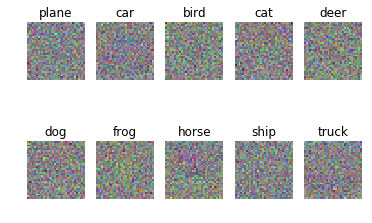

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])